In [1]:
import numpy as np
import tensorflow as tf
# next line only for colab
%tensorflow_version 2.x
tfkl = tf.keras.layers
from tensorflow.keras import Model
# import tensorflow-datasets to be able to access the tensorflow inbuilt datasets
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output

# 2. The Task


## Generator

In [2]:
# a generator that yields items instead of returning a list

def input_generator(n,num):
  """Generator that yields #num many input samples

  Arguments:
    n (int): Defines the length of the input sequence 
    num (int): Defines the amount of samples generated 

  Yields:
    sample (tuple): input-target pair 
  """
  for i in range(num):
    # randomly generate context and sequence
    context = random.sample(range(0,10),2)
    seq = list(np.random.randint(0,10,n))
  
    # calculate which of the context numbers occurs more often in the generated sequence
    if seq.count(context[0]) >= seq.count(context[1]):
      target = [1,0] 
    elif seq.count(context[0]) < seq.count(context[1]):
      target = [0,1]

    # one hot encode 
    context = tf.reshape(tf.one_hot(context, 10), (-1))
    seq = tf.one_hot(seq,10)

    # concatenate the context to each element of the sequence 
    sample = [tf.concat([context, elem],0) for elem in seq]

    yield (tf.convert_to_tensor(sample), tf.reshape(tf.convert_to_tensor(target), (-1,)))


An example sample:

In [3]:
for sample in input_generator(2,1):
  print(sample)

(<tf.Tensor: shape=(2, 30), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],
      dtype=float32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 0], dtype=int32)>)


## Input Pipeline

In [4]:
sequence_length = tf.constant(20)
num_samples = tf.constant(100000)

dataset = tf.data.Dataset.from_generator(input_generator, args=(sequence_length, num_samples), output_signature=(tf.TensorSpec(shape=(20,30),dtype=tf.float32), tf.TensorSpec(shape=(2,),dtype=tf.float32))).cache().batch(512).prefetch(tf.data.experimental.AUTOTUNE)

Have a look at one batch from the dataset:

In [5]:
for i in dataset:
  print(i)
  break

(<tf.Tensor: shape=(512, 20, 30), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0.

# The Network

In the following we create an LSMT implementation in graph mode consisting of three classes that is supposed to find out which digits out of two queried digits is more common in a given sequence:
1. LSTM_Cell that contains the three gates (input, output and forget) as well as the cell state candidate 
2. LSTM that consists of one LSTM_Cell that gets unrolled for the input sequence
3. LSTM_Model that has an additional input and output layer for our calssification task 

In [6]:
class LSTM_Cell(Model):
  """Model that realizes the internal structure and calculations of an LSTM 
  """

  def __init__(self, layersize):
    """Initialize the LSTM_Cell with a given amount of neurons in the layers of the gates.

    Arguments:
      layersize (int): defining the amount of neurons in the layers of the gates 
    """
    super(LSTM_Cell, self).__init__()

    self.forget_gate = tfkl.Dense(units=layersize, activation='sigmoid', bias_initializer='ones')
    self.input_gate = tfkl.Dense(units=layersize, activation='sigmoid')
    self.output_gate = tfkl.Dense(units=layersize, activation='sigmoid')

    self.cell_state_candidate = tfkl.Dense(units=layersize, activation='tanh')
    
  @tf.function
  def call(self, input, hidden_state, cell_state):
    """Call function where the internal calcualtions of an LSTM are performed.
    Calculates the following hidden state and cell state.

    Arguments:
      input (Tensor): Input Sequence where each element of the sequence is already concatenated with the context digits 
      hidden_state (Tensor): Previous hidden state of time step t-1
      cell_state (Tensor): Previous cell state of time step t-1

    Returns:
      output (Tensor): updated hidden state 
      cell_state (Tensor): updated cell state
    """
    concat_input = tf.concat([hidden_state, input], -1)
    cell_state = cell_state * self.forget_gate(concat_input)
    update = self.input_gate(concat_input) * self.cell_state_candidate(concat_input)
    cell_state = cell_state + update
    output = tf.nn.tanh(cell_state) * self.output_gate(concat_input)

    return output, cell_state

In [7]:
class LSTM(Model):
  """Class that consists of a singular LSTM_Cell (but could in practice also consist of multiple cells --> then we would have a multilayer LSTM)
  """

  def __init__(self):
    """Initialize the LSTM with one LSTM_Cell
    """
    super(LSTM, self).__init__()

    self.cell = LSTM_Cell(3)

  @tf.function
  def call(self, input, ht, ct):
    """Unroll the singular LSTM_Cell for the input sequence --> as many time steps as our seuqence is long.
    Recursively call the LSTM_Cell with the previous hidden state, previous cell state and current input.

    Arguments:
      input (Tensor): Input Sequence where each element of the sequence is already concatenated with the context digits 
      ht (Tensor): Previous hidden state of time step t-1
      ct (Tensor): Previous cell state of time step t-1

    Returns:
      ht (Tensor): hidden state of the last LSTM_Cell 
    """
    for idx in tf.range(input.shape[1]):
      ht, ct = self.cell(input[:,idx,:], ht, ct)

    return tf.convert_to_tensor(ht)

In [8]:
class LSTM_Model(Model):
  """Class that has an additional input and output layer for our classification task
  """
  def __init__(self):
    """Initialize the Model with a Input, LSTM and Output Layer.
    The Input layer preprocesses the input sequence befor passing it on to the LSTM.
    The output layer maps the hidden state onto two neurons and applies softmax to them in order to obtain a valid probability.
    """
    super(LSTM_Model, self).__init__()

    self.input_layer = tfkl.Dense(30)
    self.inter_layer = LSTM()
    self.output_layer = tfkl.Dense(2, activation='softmax')

  @tf.function
  def call(self, input, ht, ct):
    """Passing the Input through the netowrk layer by layer 

    Arguments:
      input (Tensor): Input Sequence where each element of the sequence is already concatenated with the context digits 
      ht (Tensor): Previous hidden state of time step t-1
      ct (Tensor): Previous cell state of time step t-1

    Returns
      output (Tensor): Prediction of the network 
    """
    x = self.input_layer(input)
    x = self.inter_layer(x, ht, ct)
    output = self.output_layer(x)

    return output

In [9]:
@tf.function
def train_step(model, input, target, loss_function, optimizer):
  """Perform a training step for a given Network by
  1. Propagating the input through the network
  2. Calculating the loss between the networks output and the true targets
  2. Performing Backpropagation and Updating the trainable variables witht the calculated gradients 
 
  Arguments:
    model (Model): given instance of an initialised  Network with all its parameters
    input (Tensor): Tensor containing the input data 
    target (Tensor): Tensor containing the respective targets 
    loss_function (keras.losses): function from keras to calculate the loss
    optimizer (keras.optimizers): function from keras defining the to be applied optimizer during learning 
 
  Returns:
    loss (Tensor): Tensor containing the loss of the Network
    accuracy (Tensor): Tensor containing the accuracy of the Network during training  
  """
  with tf.GradientTape() as tape:
    # 1.
    prediction = model(input, ht=tf.zeros((input.shape[0],3)), ct=tf.zeros((input.shape[0],3)))
    # 2.
    loss = loss_function(target, prediction)
    # 3.
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  accuracy = tf.reduce_mean(tf.cast(tf.argmax(target, axis = 1) == tf.argmax(prediction, axis = 1), tf.float32), axis=0)

  return loss, accuracy 

In [10]:
def timing(start):
  """Function to time the duration of each epoch

  Arguments:
    start (time): Start time needed for computation 
  
  Returns:
    time_per_training (time): Rounded time in seconds 
  """
  now = time.time()
  time_per_training_step = now - start
  return round(time_per_training_step, 4)

In [11]:
def visualization(train_losses, train_accuracies, num_epochs):  
  # Visualize accuracy and loss for training data. 
  # One plot training loss.
  # One plot training accuracy.

  # change the style of the plots to a nicer theme
  plt.style.use('ggplot')
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

  # plot for average loss
  ax[0].plot(train_losses, label='training')
  ax[0].set(ylabel='Loss', xlabel='Epochs', title=f'Average loss over {num_epochs} epochs')
  ax[0].legend()

  # plot for average accuracy, with annotation for the last accuracy value on our test data 
  ax[1].plot(train_accuracies, label='training')
  ax[1].set(ylabel='Accuracy', xlabel='Epochs', title=f'Average accuracy over {num_epochs} epochs')
  ax[1].legend()

  best_train_acc_indx = np.argmax(train_accuracies)
  best_train_acc = round(float(train_accuracies[best_train_acc_indx]), 4)
  if best_train_acc > 0.3:
    ax[1].annotate(f'best train accuracy {best_train_acc*100}%', xy=(best_train_acc_indx, best_train_acc), xytext=(best_train_acc_indx/2, best_train_acc-0.1), arrowprops=dict(facecolor='steelblue', shrink=0.05))
  plt.show()

In [12]:
def trainModel(network, num_epochs=150, learning_rate=0.001, running_average_factor=0.95):  

  tf.keras.backend.clear_session()

  ### Hyperparameters
  num_epochs = num_epochs
  learning_rate = learning_rate
  running_average_factor = running_average_factor
  
  # Initialize the model.
  model = network

  # Initialize the loss: binary cross entropy.
  cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
  # Initialize the optimizer: Adam with default parameters.
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  # Initialize lists for later visualization.
  train_losses = []
  train_accuracies = []

  # We train for num_epochs epochs.
  for epoch in range(num_epochs):
      
      start = time.time()

      # training
      running_average = 0
      accuracies = []
      for (input,target) in dataset:

          train_loss, accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
          running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
          accuracies.append(accuracy)
      train_losses.append(running_average.numpy())
      train_accuracies.append(np.mean(accuracies))

      # We print loss and accuracy for each epoch as well as a dynamic plot of them 
      clear_output()
      print('Epoch: ' + str(epoch+1))
      print()
      print(f"Train Loss: {round(float(train_losses[-1]), 4)}")
      print(f"Train Accuracy: {round(float(train_accuracies[-1]), 4)}")
      print()
      print(f"This epoch took {timing(start)} seconds")
      print()
      if epoch > 10:
        visualization(train_losses, train_accuracies, num_epochs)

  print()    
  model.summary()

Epoch: 150

Train Loss: 0.3918
Train Accuracy: 0.8217

This epoch took 4.4157 seconds



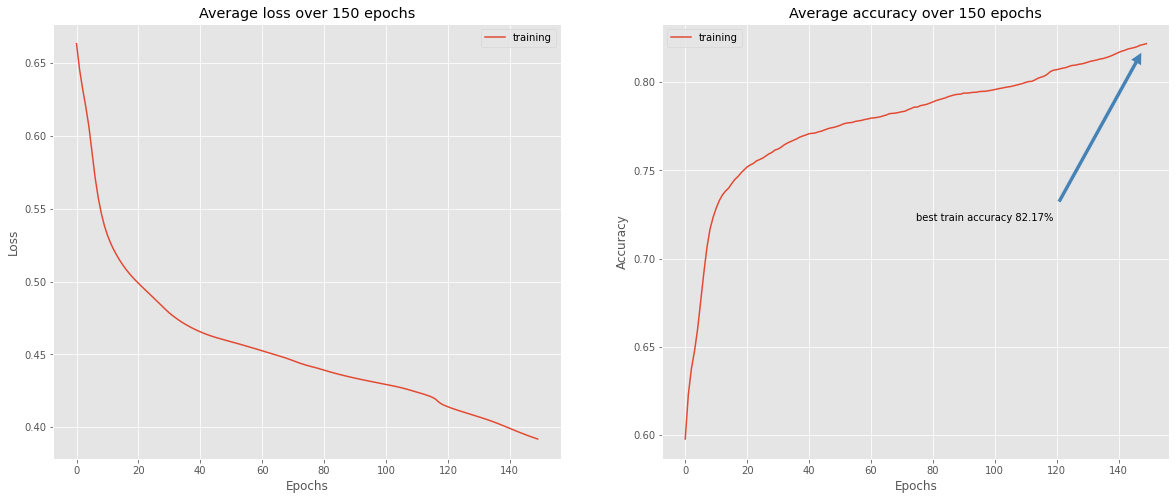


Model: "lstm__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  930       
_________________________________________________________________
lstm (LSTM)                  multiple                  408       
_________________________________________________________________
dense_5 (Dense)              multiple                  8         
Total params: 1,346
Trainable params: 1,346
Non-trainable params: 0
_________________________________________________________________


In [13]:
# As we use fairly many training samples, the initial epoch takes around 7 mins.
# Due to caching and prefetching the subsequent epochs are much faster (4 sec).
model = LSTM_Model()
trainModel(model)

# 4. Training

## Truncated BPTT:
Since we use seuqences of a fixed length it does not make sense to use TBPTT here. But if we would dertermine the seuqence lenght randomly and thus potentially having large differences between sequences in one batch, it would make sense to truncate each sequence. Otherwise the processing time of one batch is determinded by the longest sequence in the batch. 

## Classification or Regression:
Since we have a binary classification problem at hand (first context digit occurs more often or second context digit occurs more often) it wouldn't make sense to use Regression here (as we would predict a continous regression value instead of one of the two classes).